# Instalando bibliotecas

In [60]:
""" Installing libraries """
%pip install pandas==2.3.2 matplotlib==3.10.6 seaborn==0.13.2 scikit-learn==1.7.1 numpy==2.2.6 pyarrow==21.0.0 torch==2.8.0

Note: you may need to restart the kernel to use updated packages.


# Importando bibliotecas (externas e próprias)

In [62]:
""" Importing libraries """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Our modules
from Modules.loading.read_parquet import read_parquet_file 
from Modules.preprocessing.onehot import one_hot_encode_parquet
from Modules.models.NBeats import NBeatsBlock, NBeats
from Modules.models.training import train_model_NBeats
from Modules.models.WMAPELoss import WMAPELoss
from Modules.models.test import soft_test
from Modules.models.test import hard_test

ImportError: cannot import name 'hard_test' from 'Modules.models.test' (c:\Users\range\OneDrive\Área de Trabalho\Mestrado\Projetinhos\hackathon-big_data_tech\Files\Code\Modules\models\test.py)

# Definição dos hiper-parâmetros

In [ ]:
""" Defining hyper-parameters """
# Neural Network Global Parameters
input_size = 7  # Number of past days to use as input
output_size = 1  # Number of future days to predict
batch_size = 14  # Batch size for training

n_layers = 4  # Number of layers in the N-BEATS model
hidden_size = 128  # Number of hidden units in each layer

# Training parameters
learning_rate = 1e-3 # Learning rate for the optimizer
epochs = 50  # Number of training epochs (iterations over the entire dataset)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

# Importação do Dataset

É interessante dividir o treino em batches (mini-conjuntos de treino). Cada batch possui o tamanho de input size, seguindo a ordem cronológica de vendas dentro daquela janela de dias. No entanto, durante o treinamento é **ESSENCIAL** que a escolha do próximo batch seja aleatória.

Ex.: Inicia o treino por 21-27 jul e prevê 28, depois pula para 02-08 fev para prever 03. Esse processo deve ser repetido até todos os dados serem treinados, finalizando **01 epoch**.

O número de **epochs** diz o número total de iterações do modelo com relação ao dataset inteiro.

Sobre a composição da janela de input dentro de um batch, existem duas abordagens:

1) Treinar em cada janela todas as séries (pense que cada par produto-loja x tempo representa uma série temporal dentro daquele período). Esse modelo é bem mais complexo pois o output deve ter o mesmo tamanho de produto-loja.
2) Treinar vários modelos separados (considerando uma série temporal para cada modelo). Esse método é ineficiente pois o modelo nunca irá aprender os padrões entre as séries.
3) Treinar o modelo com um par produto-loja por vez. Ou seja:
   - O modelo realiza epochs = N iterações de treino ao longo de todo dataset
     - Em cada epoch, passa por todas as M batches
       - Em cada batch (que possui uma janela de tamanho input_size), atualiza os parâmetros para cada série temporal ($x_l,y_l$). Totalizando L atualizações, com L sendo o número de pares produto-loja.

Ressalta-se que cada conjunto ($x_l,y_l$) representa:
- $x_l$: série temporal do l-ésimo par produto-loja, sendo um vetor de tamanho input_size x (features + 1)
- $y_l$: Previsão de vendas do l-ésimo par produto-loja para os próximos $output_size$ dias


In [ ]:
""" Setting up the constants """

DATA_PATH = "../Data/hackathon_2025_templates/part-00000-tid-"

FILE_HASH = [
    "2779033056155408584-f6316110-4c9a-4061-ae48-69b77c7c8c36",
    "5196563791502273604-c90d3a24-52f2-4955-b4ec-fb143aae74d8",
    "7173294866425216458-eae53fbf-d19e-4130-ba74-78f96b9675f1",
]

SUFIX = "-4-1-c000.snappy.parquet"

FILE_NAMES = [DATA_PATH + hash + SUFIX for hash in FILE_HASH]

In [ ]:
""" Loading the data """

pdv_data = read_parquet_file(FILE_NAMES[0])
transaction_data = read_parquet_file(FILE_NAMES[1])
product_data = read_parquet_file(FILE_NAMES[2])

In [ ]:
pdv_data.head()

,pdv,premise,categoria_pdv,zipcode
0,2204965430669363375,On Premise,Mexican Rest,30741
1,5211957289528622910,On Premise,Hotel/Motel,80011
2,9024493554530757353,Off Premise,Convenience,80751
3,8659197371382902429,On Premise,Restaurant,80439
4,1400854873763881130,On Premise,Restaurant,30093


In [ ]:
transaction_data.head()

,internal_store_id,internal_product_id,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes
0,7384367747233276219,328903483604537190,9,2022-07-13,2022-07-01,1.0,38.125000,37.890625,10.042625,3.950000,0.234375
1,3536908514005606262,5418855670645487653,5,2022-03-21,2022-03-01,6.0,107.250000,106.440002,24.732002,17.100000,0.810000
2,3138231730993449825,1087005562675741887,6,2022-09-06,2022-09-01,3.0,56.625000,56.220001,14.124002,5.250000,0.405000
3,3681167389484217654,1401422983880045188,5,2022-09-11,2022-09-01,129.0,1037.160023,1037.160023,156.348026,479.880006,0.000000
4,7762413312337359369,6614994347738381720,4,2022-02-18,2022-02-01,1.0,26.230000,23.950241,6.550241,0.000000,2.279758


In [ ]:
product_data.head()

,produto,categoria,descricao,tipos,label,subcategoria,marca,fabricante
0,2282334733936076502,Distilled Spirits,JOSEPH CARTRON CAFÉ LIQUEUR,Distilled Spirits,Core,Liqueurs & Cordials,Joseph Cartron Cafe,Spiribam
1,6091840953834683482,Distilled Spirits,SPRINGBANK 18 YEAR SINGLE MALT 700ML,Distilled Spirits,Specialty,Scotch Whisky,Springbank 18 Year Single Malt,Pacific Edge Wine & Spirits
2,1968645851245092408,Distilled Spirits,J BRANDT TRIPLE SEC 12/750ML 30PF,Distilled Spirits,Private Label,Liqueurs & Cordials,J Brandt Triple Sec,Sazerac Spirits
3,994706710729219179,Draft,REFORMATION CASHMERE IPA 1/4 KEG,Draft,In&Out,Other Draft,Reformation Cashmere Fresh Hop IPA,Reformation Brewery
4,9209550539540384349,Non-Alcohol,HELLA MOSCOW MULE 750ML,Non Alcohol,Core,Mixers,Hella Bitters Bloody Mary,Hella Bitter Llc


# Reorganizando os dados em pares produto-loja

In [ ]:

# 1) juntar produto
df = transaction_data.merge(
    product_data,
    left_on="internal_product_id",
    right_on="produto",
    how="left"
)

# 2) juntar loja
df = df.merge(
    pdv_data,
    left_on="internal_store_id",
    right_on="pdv",
    how="left"
)

# 3) garantir que a data esteja no formato datetime
df["transaction_date"] = pd.to_datetime(df["transaction_date"])

# 4) pivotar: dia x par produto-loja
full_df = (
    df.pivot_table(
        index="transaction_date",                        # agora usa transaction_date
        columns=["internal_product_id", "internal_store_id"],  
        values="quantity",                               # mantenha 'quantity' se esse for o nome certo
        aggfunc="sum",
        fill_value=0
    )
)

# 5) deixar colunas mais legíveis: produto_loja
full_df.columns = [f"{p}_{l}" for p, l in full_df.columns]

# 6) garantir todas as datas do período (mesmo sem vendas)
full_df = full_df.reindex(
    pd.date_range(df["transaction_date"].min(), df["transaction_date"].max(), freq="D"),
    fill_value=0
)
full_df.index.name = "data"


# Transformando o Dataframe em um Dataset

In [ ]:
# Exemplo único e aleatório de uma série temporal
##dataset = full_df[full_df.columns[232]].values

n_data = 1000
time = np.linspace(0, 20 * np.pi, n_data)

dataset = np.sin(time) + 0.5 * np.sin(3 * time) + 0.2 * np.sin(5 * time) + 0.1 * np.random.randn(n_data)


# Inicializando os vetores de entrada e os rótulos
X = []
y = []

# Número total de amostras que podem ser extraídas
n_samples = len(dataset) - input_size - output_size + 1

# Extraindo janelas deslizantes
for i in range(n_samples):
    x_window = dataset[i:i+input_size]                   # últimos input_size dias
    y_window = dataset[i+input_size:i+input_size+output_size]  # próximo dia

    X.append(x_window)
    y.append(y_window)

# Convertendo para arrays numpy e depois para tensores PyTorch
X = np.array(X)  # shape = [n_samples, input_size]
y = np.array(y)  # shape = [n_samples, output_size]

X = torch.tensor(X, dtype=torch.float32)  # shape = [n_samples, input_size, 1]

y = torch.tensor(y, dtype=torch.float32)  # shape = [n_samples, 1]

" Definindo o Dataset e DataLoader do PyTorch "
class SingleSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset_full = SingleSeriesDataset(X, y)

# Separando os dados entre treino / validação

Os dados serão separados na proporção 80% - treino / 20% validação. Para séries temporais, é usual que essa separação seja feita de forma cronológica

In [ ]:
# Ponto de separação entre treino e validação
split_point = int(0.8 * len(dataset_full))

# Separação cronológica das janelas
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]


print(f"Há um total de {len(dataset_full)} janelas e o split_point = {split_point}, em 80%")

Há um total de 993 janelas e o split_point = 794, em 80%


# Treinamento

In [ ]:
# Adotando o dataset de treino
dataset = SingleSeriesDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size, shuffle=False) # shuffle=False para séries tempor

# Inicialização do modelo N-BEATS
model = NBeats(input_size, hidden_size, output_size=output_size).to(device)

model, criterion, optimizer = train_model_NBeats(model, learning_rate, epochs, device, dataloader)


Epoch 1/50, Loss: 0.1757
Epoch 2/50, Loss: 0.0444
Epoch 3/50, Loss: 0.0173
Epoch 4/50, Loss: 0.0168
Epoch 5/50, Loss: 0.0180
Epoch 6/50, Loss: 0.0211
Epoch 7/50, Loss: 0.0162
Epoch 8/50, Loss: 0.0172
Epoch 9/50, Loss: 0.0209
Epoch 10/50, Loss: 0.0190
Epoch 11/50, Loss: 0.0170
Epoch 12/50, Loss: 0.0198
Epoch 13/50, Loss: 0.0179
Epoch 14/50, Loss: 0.0190
Epoch 15/50, Loss: 0.0164
Epoch 16/50, Loss: 0.0161
Epoch 17/50, Loss: 0.0173
Epoch 18/50, Loss: 0.0191
Epoch 19/50, Loss: 0.0220
Epoch 20/50, Loss: 0.0156
Epoch 21/50, Loss: 0.0159
Epoch 22/50, Loss: 0.0167
Epoch 23/50, Loss: 0.0158
Epoch 24/50, Loss: 0.0187
Epoch 25/50, Loss: 0.0193
Epoch 26/50, Loss: 0.0171
Epoch 27/50, Loss: 0.0155
Epoch 28/50, Loss: 0.0168
Epoch 29/50, Loss: 0.0161
Epoch 30/50, Loss: 0.0155
Epoch 31/50, Loss: 0.0173
Epoch 32/50, Loss: 0.0171
Epoch 33/50, Loss: 0.0178
Epoch 34/50, Loss: 0.0152
Epoch 35/50, Loss: 0.0149
Epoch 36/50, Loss: 0.0155
Epoch 37/50, Loss: 0.0160
Epoch 38/50, Loss: 0.0165
Epoch 39/50, Loss: 0.

# Validação do modelo

São feitos dois testes:

- **Soft test:** Modelo  tenta fazer as previsões, mas não utiliza-as nas previsões futuras, utiliza sempre os *ground truth* como input
- **Hard test:** Modelo tenta fazer as previsões, e utiliza $y_{i-1}$ para a previsão de $y_i$

In [ ]:
all_preds_S, all_targets_S, avg_loss_test_S = soft_test(model, dataloader, device, criterion)

all_preds_H, all_targets_H, avg_loss_test_H = hard_test(model, dataloader, device, output_size, criterion)

Val Loss: 0.0191


NameError: name 'hard_test' is not defined

(993, 7) (993, 1) 7 1
1000


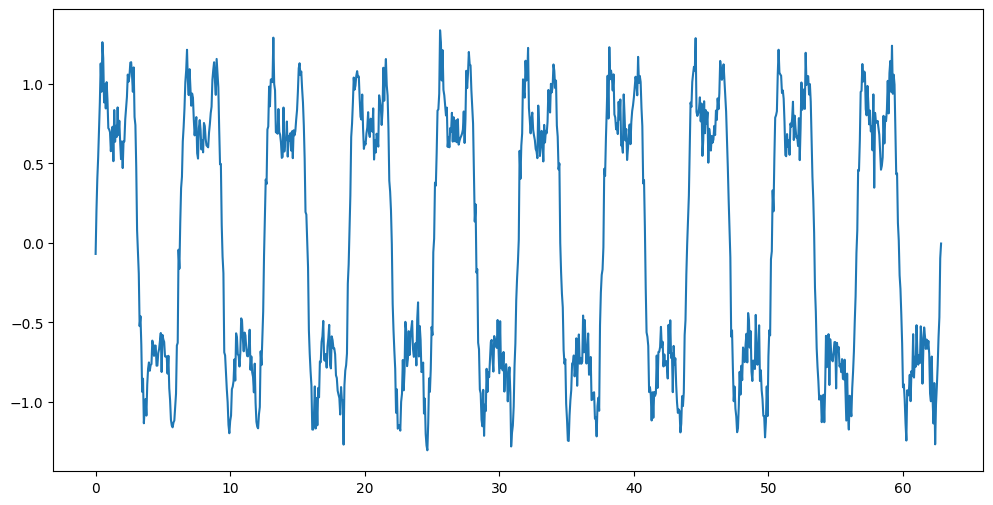

In [ ]:
n_samples = 1000
time = np.linspace(0, 20 * np.pi, n_samples)

dataset = np.sin(time) + 0.5 * np.sin(3 * time) + 0.2 * np.sin(5 * time) + 0.1 * np.random.randn(n_samples)

# Inicializando os vetores de entrada e os rótulos
X = []
y = []

# Número total de amostras que podem ser extraídas
n_samples = len(dataset) - input_size - output_size + 1

# Extraindo janelas deslizantes
for i in range(n_samples):
    x_window = dataset[i:i+input_size]                   # últimos input_size dias
    y_window = dataset[i+input_size:i+input_size+output_size]  # próximo dia

    X.append(x_window)
    y.append(y_window)

# Convertendo para arrays numpy e depois para tensores PyTorch
X = np.array(X)  # shape = [n_samples, input_size]
y = np.array(y)  # shape = [n_samples, output_size]

print(X.shape, y.shape, input_size, output_size)
print(len(dataset))
plt.figure(figsize=(12, 6))
plt.plot(time, dataset, label='Série Temporal Sintética')

